In [36]:
import torch
import torch.nn as nn # for the super classes and layers
import torch.optim as optim
import torch.nn.functional as func # for activation functions etc..
from torch.utils.data import Dataset, DataChunk, DataLoader # for loading data as chunks
from torchvision import transforms # image to tensor thing
import torch.nn.init as init

from tqdm import tqdm

from torchsummary import summary # getting the summary of the architecture

import matplotlib.pyplot as plt
import cv2
import numpy
import os
from PIL import Image

In [ ]:
# We need to track two things for camera tracking, 
#    1 -> direction.
#    2 -> location.
#
# The ML model aids us selecting what to track, and because we need to track the camera for more than just the objects that appear at the 
# beginning of the video, we need to drop objects and pickup new objects with the duration of the clip.
#
#
#
#
#
#
#

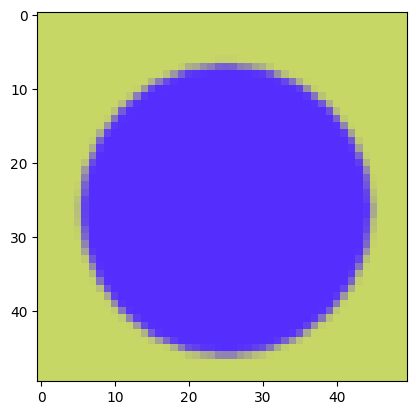

In [21]:
img = Image.open("shapes/output/Circle_0a0b51ca-2a86-11ea-8123-8363a7ec19e6.png")
changer = transforms.Compose([
    transforms.Resize((50, 50))
])
img = changer(img)
plt.imshow(img)

In [37]:
# Model Architecture
class SmallShapeLearn(nn.Module):

    def __init__(self, num_classes = 9):
        super(SmallShapeLearn, self).__init__()
        # for 200*200 as the input.
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = func.relu(self.conv1(x))
        x = self.pool1(x)
        #  \
        x = func.relu(self.conv2(x))
        x = self.pool2(x)
        #   \
        x = func.relu(self.conv3(x))
        x = self.pool3(x)
        #     \
        x = x.view(-1, 64 * 7 * 7) 
        x = func.relu(self.fc1(x))
        #       \
        x = self.fc2(x)
        #        \
        return func.log_softmax(x, dim=1)

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Initializing Conv2d layers with Xavier (Glorot) initialization
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Initializing Linear layers with Xavier (Glorot) initialization
                init.xavier_normal_(m.weight)
                init.constant_(m.bias, 0)

In [32]:
# model summary
model = SmallShapeLearn(num_classes=9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, (1, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 50, 50]             160
         MaxPool2d-2           [-1, 16, 25, 25]               0
            Conv2d-3           [-1, 32, 27, 27]           4,640
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 15, 15]          18,496
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                   [-1, 64]         200,768
            Linear-8                    [-1, 9]             585
Total params: 224,649
Trainable params: 224,649
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.74
Params size (MB): 0.86
Estimated Total Size (MB): 1.60
----------------------------------------------------------------


In [ ]:
# Initialize lists to store costs and steps
costs = []
steps = []

# Create a function to update the plot
def update_plot(epoch, batch_idx, cost):
    plt.plot(steps, costs, label='Cost')
    plt.xlabel('Step')
    plt.ylabel('Cost')
    plt.title(f'Epoch {epoch + 1}, Batch {batch_idx + 1}')
    plt.legend()
    plt.show()

In [33]:
# DataSet loading
shape_label_dictionary = {"Triangle" : 0,
                          "Square" : 1,
                          "Pentagon" : 2,
                          "Hexagon" : 3,
                          "Heptagon" : 4,
                          "Octagon" : 5,
                          "Nonagon" : 6,
                          "Circle" : 7,
                          "Star" : 8}

class ShapeDataset(Dataset):

    def __init__(self, path):
        self.root_dir = path
        self.image_files = [f for f in os.listdir(path) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, id):
        img_name = os.path.join(self.root_dir, self.image_files[id])
        image = Image.open(img_name).convert('L')
        label = self.image_files[id].split('_')[0]

        transform = transforms.Compose([
            transforms.Resize((50, 50)),
            transforms.ToTensor(),
        ])

        image = transform(image)
        label = shape_label_dictionary[label]
        
        return image, label

In [ ]:
# Setting up for training
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

model = SmallShapeLearn(num_classes=9)
model.initialize_weights()


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


train_dataset = ShapeDataset('shapes/output')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 10
device = torch.device("cpu")
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2813/2813 [01:17<00:00, 36.49it/s]


Epoch 1/10, Loss: 2.2005


Epoch 2/10:  39%|██████████████████████████████████▎                                                    | 1109/2813 [00:34<00:52, 32.51it/s]

In [ ]:
#### PROTOTYPE ####

In [ ]:
# FILTERS AND TRACKING #


video_path = 'test/footage.mp4'
video = cv2.VideoCapture(video_path)
kernel = numpy.array([[2 , 1 , 2], 
                      [1 ,-12 , 1], 
                      [2 , 1 , 2]])

kernel2 = numpy.array([[1, 1 , 2 , 1, 1],
                      [1, 3 , 3 , 3, 1], 
                      [1, 3 ,-44 , 3,1], 
                      [1, 3 , 3 , 3, 1],
                      [1, 1 , 2 , 1, 1]])


kernel3 = numpy.array([[-1, -1 , -2, -1, -1],
                      [-1, -3 , -3 , -3, -1], 
                      [-1, -3 , 50 , -3, -1], 
                      [-1, -3 , -3 , -3, -1],
                      [-1, -1 , -2 , -1, -1]])


def draw_lines(frame):
    
    lines = cv2.HoughLines(frame, 1, numpy.pi / 180, threshold=500)

    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = numpy.cos(theta)
            b = numpy.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(frame, (x1, y1), (x2, y2), (255, 0, 255), 2)


if not video.isOpened():
    print("Error: Could not open video file(mostly, file not found)")
else:
    # play video with filters.
    while (1):
        ret, frame = video.read()

        if not ret:
            print("Error: Failed to capture frame.")
            break
        frame = cv2.resize(frame, (1920, 1080))

        frame = cv2.GaussianBlur(frame, (3, 3), 0);
        frame = cv2.filter2D(frame, -1, kernel2);
        
        cv2.imshow('Video', frame)

        # if the pressed key in 30 ms is `q`, quit.
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    
    video.release()
    cv2.destroyAllWindows()